Note: Attach > 1 GPUs with the notebook instance, for distributed training.

Also, install GPU version of TF

In [1]:
import datetime as dt
import tensorflow as tf

import warnings 
warnings.filterwarnings("ignore") 

# %load_ext tensorboard

2021-11-11 07:47:05.144985: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))

TensorFlow version2.5.0
Built with GPU support? Yes!
There are 2 GPUs


2021-11-11 07:47:06.445155: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-11 07:47:09.679819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:47:09.680682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-11-11 07:47:09.680796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:47:09.681574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:00:05.0 n

Check GPUs

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2021-11-11 07:47:09.720762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 07:47:09.842662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:47:09.843838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-11-11 07:47:09.844009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there m

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import os, shutil
from tensorflow.data.experimental import AUTOTUNE

In [5]:
IMG_HEIGHT = 448
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 3
CLASS_NAMES = 'Fire No-Fire'.split()

batch_size = 8

CHECKPOINT_DIR='./chkpts'
OUTDIR = './export'

Look at the tfrecord files lying in GCS

In [6]:
tfrecords_in_gcs = "gs://fire_detection_anurag/tfrecords/"

tf.io.gfile.listdir(tfrecords_in_gcs)

['test-00000-of-00002.gz',
 'test-00001-of-00002.gz',
 'train-00000-of-00002.gz',
 'train-00001-of-00002.gz',
 'valid-00000-of-00002.gz',
 'valid-00001-of-00002.gz']

Choose accordingly

In [7]:
PATTERN_SUFFIX = '-*'
NUM_EPOCHS = 15

training_data_tfr = tfrecords_in_gcs  + "train" + PATTERN_SUFFIX
validation_data_tfr = tfrecords_in_gcs + "valid" + PATTERN_SUFFIX

Strategy for distributed training

In [8]:
def setup_trainer():
    shutil.rmtree(CHECKPOINT_DIR,
                  ignore_errors=True)
    os.mkdir(CHECKPOINT_DIR)
    shutil.rmtree(OUTDIR,
                  ignore_errors=True)
    os.mkdir(OUTDIR)
    # Load compressed models from tensorflow_hub
    os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

    
def create_strategy(mode='gpus_one_machine'):
    """
    mode has be to be one of the following:
    * gpus_one_machine
    * gpus_multiple_machines
    """
    if mode == 'gpus_one_machine':
        print('Using {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
        return tf.distribute.MirroredStrategy()
    if mode == 'gpus_multiple_machines':
        print("Using TFCONFIG=", os.environ["TF_CONFIG"])
        return tf.distribute.MultiWorkerMirroredStrategy()
    

setup_trainer()
strategy = create_strategy()

Using 2 GPUs


2021-11-11 07:47:11.057618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:47:11.058851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-11-11 07:47:11.059030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:47:11.060449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:00:05.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-1

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
strategy.num_replicas_in_sync

2

In [10]:
GLOBAL_BATCH_SIZE = batch_size * strategy.num_replicas_in_sync

Helper functions

In [19]:
def training_plot(metrics, history):
    
    f, ax = plt.subplots(1, len(metrics),
                         figsize=(5*len(metrics), 5))
    
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

    
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    
    def read_from_tfr(self, proto):
        feature_description = {
                                'image': tf.io.VarLenFeature(tf.float32),
                                'shape': tf.io.VarLenFeature(tf.int64),
                                'label': tf.io.FixedLenFeature([], tf.string,
                                                               default_value=''),
                                'label_int': tf.io.FixedLenFeature([], tf.int64,
                                                                   default_value=0),
                              }
        rec = tf.io.parse_single_example(
                                        proto,
                                        feature_description
                                        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    
    def read_from_jpegfile(self, filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img,
                                   channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
        
    def preprocess(self, img):
        return tf.image.resize_with_pad(img,
                                        IMG_HEIGHT,
                                        IMG_WIDTH)

    
# split the files into two halves and interleaves datasets
def create_preproc_dataset(pattern):
    """
    Does interleaving, parallel calls, prefetch, batching
    Caching is not a good idea on large datasets.
    """
    preproc = _Preprocessor()
    files = [filename for filename in tf.random.shuffle(tf.io.gfile.glob(pattern))]
    
    if len(files) > 1:
        print("Interleaving the reading of {} files.".format(len(files)))
        
        
        def _create_half_ds(x):
            if x == 0:
                half = files[:(len(files)//2)]
            else:
                half = files[(len(files)//2):]
                
            return tf.data.TFRecordDataset(half,
                                           compression_type='GZIP')
        
        
        ds = tf.data.Dataset.range(2).interleave(_create_half_ds,
                                                 num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.TFRecordDataset(files,
                                     compression_type='GZIP')
        
        
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    
    
    ds = (ds
           .map(preproc.read_from_tfr,
                num_parallel_calls=AUTOTUNE)
           .map(_preproc_img_label,
                num_parallel_calls=AUTOTUNE)
           .shuffle(200)  # TODO
           .prefetch(AUTOTUNE)
         )
    
    return ds


# for inferencing/prediction, we won't have tfrecords
def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

In [12]:
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

In [31]:
def create_model(l1, l2,
                 num_hidden):
    
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
        
    layers = [
              tf.keras.layers.experimental.preprocessing.RandomCrop(
                                                                  height=IMG_HEIGHT//2,
                                                                  width=IMG_WIDTH//2,
                                                                  input_shape=(IMG_HEIGHT,
                                                                               IMG_WIDTH,
                                                                               IMG_CHANNELS),
                                                                  name='random/center_crop'
                                                                   ),
              tf.keras.layers.experimental.preprocessing.RandomFlip(
                                                                  mode='horizontal',
                                                                  name='random_lr_flip'
                                                                   ),
              RandomColorDistortion(name='random_contrast_brightness/none'),
              hub.KerasLayer(
                              "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                              trainable=False,
                              name='mobilenet_embedding'
                            ),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu,
                                    name='dense_hidden_1'),
              tf.keras.layers.Dense(int(num_hidden / 2),
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu,
                                    name='dense_hidden_2'),
              tf.keras.layers.Dense(len(CLASS_NAMES),  # TODO: len(CLASS_NAMES)
                                    kernel_regularizer=regularizer,
                                    activation='softmax',  # TODO: softmax/sigmoid?
                                    name='fire_detector')
            ]

    # create model
    return tf.keras.Sequential(layers,
                               name='fire_detection')

In [32]:
timestamp = dt.datetime.now().strftime("%Y-%m-%d_%H%M%S")

timestamp

'2021-11-11_080640'

In [33]:
def train_and_evaluate(
                       strategy,
                       batch_size = GLOBAL_BATCH_SIZE,
                       lrate = 0.015,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 32
                      ):
    
    train_dataset = create_preproc_dataset(
                                           training_data_tfr
                                          ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
                                          validation_data_tfr
                                         ).batch(batch_size)

    # callbacks
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
                                                            filepath='./chkpts',
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True
                                                            )
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
                                                         monitor='val_accuracy',
                                                         mode='max',
                                                         patience=2
                                                        )
    
#     tensorboard_cb = tf.keras.callbacks.TensorBoard(
#                                                     log_dir=f'./tensorboardlogs/',  # TODO: timestamp sub-folder?
#                                                     write_graph=True,  # model graph
#                                                     write_images=True,  # change in weights wrt epochs
#                                                     histogram_freq=1  # epoch-wise visualization
#                                                    )
    
    # model training
    with strategy.scope():
        model = create_model(l1, l2, num_hidden)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                                                                     from_logits=False
                                                                    ),
                  metrics=['accuracy']  # Our dataset/classes are not really imbalanced.
                 )
    
    print(model.summary())
    
    history = model.fit(
                        train_dataset, 
                        validation_data=eval_dataset,
                        epochs=NUM_EPOCHS,
                        callbacks=[
                                   model_checkpoint_cb,
                                   early_stopping_cb,
#                                    tensorboard_cb
                                  ]
                       )
    
    training_plot(['loss', 'accuracy'], history)
    
    return model

In [34]:
!rm -rf ./tensorboardlogs/

Interleaving the reading of 2 files.
Interleaving the reading of 2 files.
Model: "fire_detection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip (RandomFlip)  (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_brightness/n (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden_1 (Dense)       (None, 32)                40992     
_________________________________________________________________
dense_hidden_2 (Dense)       (None, 16)                528       
____________________________________________

INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


115/115 [==============================] - 30s 170ms/step - loss: 0.3448 - accuracy: 0.8832 - val_loss: 0.1455 - val_accuracy: 0.9462


INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


Epoch 2/15
115/115 [==============================] - 19s 156ms/step - loss: 0.1986 - accuracy: 0.9234 - val_loss: 0.1398 - val_accuracy: 0.9478


INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets


Epoch 3/15
115/115 [==============================] - 20s 164ms/step - loss: 0.2162 - accuracy: 0.9201 - val_loss: 0.1422 - val_accuracy: 0.9416
Epoch 4/15
115/115 [==============================] - 20s 163ms/step - loss: 0.2045 - accuracy: 0.9217 - val_loss: 0.1381 - val_accuracy: 0.9416


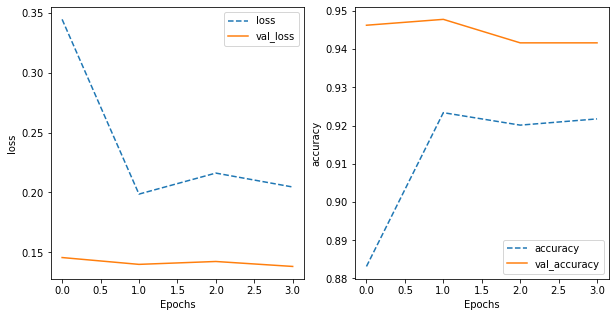

In [35]:
model = train_and_evaluate(strategy)

# %tensorboard --logdir='./tensorboardlogs/'

Save/Load/Predict

In [36]:
@tf.function(input_signature=[tf.TensorSpec([None,],
                                            dtype=tf.string)])
def predict_image_type(filenames):
    
    input_images = tf.map_fn(
                            create_preproc_image,
                            filenames,
                            fn_output_signature=tf.float32
                            )
    
    batch_pred = model(input_images)
    
    top_prob = tf.math.reduce_max(batch_pred,
                                  axis=[1])
    
    pred_label_index = tf.math.argmax(batch_pred,
                                      axis=1)
    
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES),
                           pred_label_index)
    
    return {
            'probability': top_prob,
            'image_type_int': pred_label_index,
            'image_type_str': pred_label
           }

In [37]:
model.save(
           os.path.join(OUTDIR, 'fire_model'),
           signatures={
                       'serving_default': predict_image_type
                      }
          )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


INFO:tensorflow:Assets written to: ./export/fire_model/assets


INFO:tensorflow:Assets written to: ./export/fire_model/assets


In [38]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir export/fire_model

2021-11-11 08:10:28.705570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['filenames'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_filenames:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['image_type_int'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall:0
  outputs['image_type_str'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall:1
  outputs['probability'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall:2
Method name is: tensorflow/serving/predict


In [39]:
filenames = tf.io.gfile.glob("gs://fire_detection_anurag/test_images/*")

filenames

['gs://fire_detection_anurag/test_images/fire1.jpg',
 'gs://fire_detection_anurag/test_images/fire2.jpg',
 'gs://fire_detection_anurag/test_images/fire3.jpg',
 'gs://fire_detection_anurag/test_images/fire4.jpg',
 'gs://fire_detection_anurag/test_images/fire5.jpg',
 'gs://fire_detection_anurag/test_images/no_fire1.jpg',
 'gs://fire_detection_anurag/test_images/no_fire2.jpg',
 'gs://fire_detection_anurag/test_images/no_fire3.jpg',
 'gs://fire_detection_anurag/test_images/no_fire4.jpg',
 'gs://fire_detection_anurag/test_images/no_fire5.jpg',
 'gs://fire_detection_anurag/test_images/prediction-fire20211105140403-2021-11-05T15:04:29.256648Z',
 'gs://fire_detection_anurag/test_images/test.jsonl']

In [40]:
filenames = filenames[:10]

serving_model = tf.keras.models.load_model('export/fire_model')

input_images = [create_preproc_image(f) for f in filenames]

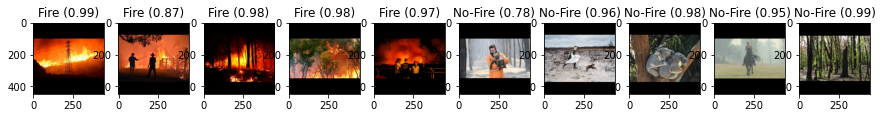

In [41]:
f, ax = plt.subplots(1, 10, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1,
                                   IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]
                            )
    batch_pred = serving_model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))

In [42]:
## it's better to vectorize the prediction
filenames = tf.convert_to_tensor(filenames)
print(filenames)

input_images = tf.map_fn(create_preproc_image, 
                         filenames,
                         fn_output_signature=tf.float32)

batch_pred = serving_model.predict(input_images)
print('full probs:\n', batch_pred)

top_prob = tf.math.reduce_max(batch_pred,
                              axis=[1])
print('top prob:\n', top_prob)

pred_label_index = tf.math.argmax(batch_pred,
                                  axis=1)
print('top cls:\n', pred_label_index)

pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
print(pred_label)

tf.Tensor(
[b'gs://fire_detection_anurag/test_images/fire1.jpg'
 b'gs://fire_detection_anurag/test_images/fire2.jpg'
 b'gs://fire_detection_anurag/test_images/fire3.jpg'
 b'gs://fire_detection_anurag/test_images/fire4.jpg'
 b'gs://fire_detection_anurag/test_images/fire5.jpg'
 b'gs://fire_detection_anurag/test_images/no_fire1.jpg'
 b'gs://fire_detection_anurag/test_images/no_fire2.jpg'
 b'gs://fire_detection_anurag/test_images/no_fire3.jpg'
 b'gs://fire_detection_anurag/test_images/no_fire4.jpg'
 b'gs://fire_detection_anurag/test_images/no_fire5.jpg'], shape=(10,), dtype=string)
full probs:
 [[0.9882135  0.01178651]
 [0.86791825 0.13208176]
 [0.9781214  0.02187859]
 [0.9799422  0.0200578 ]
 [0.97430235 0.02569767]
 [0.22464831 0.77535164]
 [0.03888128 0.96111876]
 [0.01963598 0.98036397]
 [0.04661939 0.9533806 ]
 [0.01238069 0.9876193 ]]
top prob:
 tf.Tensor(
[0.9882135  0.86791825 0.9781214  0.9799422  0.97430235 0.77535164
 0.96111876 0.98036397 0.9533806  0.9876193 ], shape=(10,), dt

In [43]:
serving_fn = tf.keras.models.load_model(
                                        os.path.join(OUTDIR, 'fire_model')
                                       ).signatures['serving_default']

# filenames = filenames[:10]

pred = serving_fn(tf.convert_to_tensor(filenames))

print(pred)
print('******')
print(pred['image_type_str'].numpy())

{'image_type_str': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Fire', b'Fire', b'Fire', b'Fire', b'Fire', b'No-Fire',
       b'No-Fire', b'No-Fire', b'No-Fire', b'No-Fire'], dtype=object)>, 'image_type_int': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])>, 'probability': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.99200773, 0.86791825, 0.9743757 , 0.9799422 , 0.97430235,
       0.77535164, 0.96111876, 0.98036397, 0.9516498 , 0.9876193 ],
      dtype=float32)>}
******
[b'Fire' b'Fire' b'Fire' b'Fire' b'Fire' b'No-Fire' b'No-Fire' b'No-Fire'
 b'No-Fire' b'No-Fire']


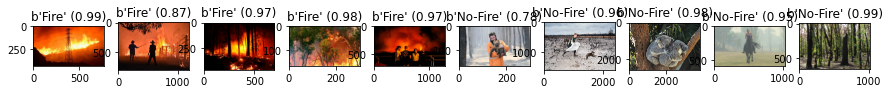

In [44]:
f, ax = plt.subplots(1, 10,
                     figsize=(15,15))

for idx, (filename, prob, pred_label) in enumerate(
                                                    zip(filenames, pred['probability'].numpy(),
                                                        pred['image_type_str'].numpy())
                                                  ):
    
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img,
                               channels=3)
    ax[idx].imshow((img.numpy()));
    
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))